# Get all the packages we need to connect With PostgreSQL 

In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib as plt

%matplotlib inline

# Create Connection Script to Database.

We must first download and install the PostgreSQL with PostGIS extension.
Then you need to create the database to later store the OSM data. 
Create the hstore extension using pgAdmin to store osm-tags in PostGIS: 

CREATE EXTENSION hstore;
CREATE EXTENSION postgis;

In [4]:
from sqlalchemy import create_engine 
from sqlalchemy_utils import create_database, database_exists, drop_database


# Postgres username, password, and database name 
POSTGRES_ADDRESS = 'http://127.0.0.1/'  
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres'  
POSTGRES_DBNAME = 'postgres' 

# A long string that contains the necessary Postgres login information 
postgres_str = ('postgresql://{username}:{port}/{dbname}'
                  .format(username=POSTGRES_USERNAME, 
                   port=POSTGRES_PORT, 
                   dbname=POSTGRES_DBNAME)) 

# Create the connection 

engine = create_engine('postgresql://postgres: @localhost:5432/postgres') 

# Connect database then add schema

pgsnapshot schemas are PostgreSQL schemas utilising postgis extensions that are capable of storing snapshots of OSM data.
The purpose of the pgsnapshot schema is similar but maximises performance through CLUSTERed indexes and embedded tag data.  It imposes additional programming complexity.

The following scripts are available for both schemas:

pgxxx_schema_0.x.sql - The schema creation script.
pgxxx_schema_0.x_linestring.sql - A script for adding way linestring column support.

In our program, we join both schemas into 1 file. (pgsnapshot_schema_0.6.sql)



In [5]:

try: 
    conn = psycopg2.connect(database='postgres', user='postgres') 
    conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
    cursor = conn.cursor()

    sqlfile = open('pgsnapshot_schema_0.6.sql', 'r')
    cursor.execute(sqlfile.read())
    conn.commit()
    print("Table created successfully in PostgreSQL ")
except (Exception, psycopg2.DatabaseError) as error :
    print ("Error while creating PostgreSQL table", error)
finally:
    #closing database connection.
        if(conn):
            cursor.close()
            conn.close()
            print("PostgreSQL connection is closed")
    



Table created successfully in PostgreSQL 
PostgreSQL connection is closed


For better performance add indices

In [52]:
#pd.read_sql_query('''CREATE INDEX idx_nodes_tags ON nodes USING GIN(tags);''', engine)
#pd.read_sql_query('''CREATE INDEX idx_ways_tags ON ways USING GIN(tags);''', engine)
#pd.read_sql_query('''CREATE INDEX idx_relations_tags ON relations USING GIN(tags);''', engine)

# Now the database is ready to be filled with the OSM data, we need to download osm data from GeoFabrik

In [8]:
import wget

print('Beginning file download with wget module')

url = 'https://download.geofabrik.de/europe/poland/malopolskie-latest.osm.pbf'
wget.download(url, 'D:/master-material/semester1/ADS/project/malopolskie-latest.osm.pbf')

Beginning file download with wget module


'D:/master-material/semester1/ADS/project/malopolskie-latest.osm.pbf'

# Crop dump osm file according to the bounding from overpass api using osmosis

Because the smallest OSM dump from GeoFabrik is Malopolskie region and we need to analyze the Cracow City only, we have to crop it using Overpass Turbo API. 

1. Open the Overpass Turbo API
2. Estimate the bounding box which contains the region's boundary
3. Save a margin of certain width to be used to crop the OSM dump of Malopolskie

In [23]:
import subprocess
subprocess.call(['D:/master-material/semester1/ADS/osmosis/bin/osmosis.bat','--read-pbf','D:/master-material/semester1/ADS/project/malopolskie-latest.osm.pbf',
                 '--bounding-box','top=50.1712','left=19.685','bottom=49.9221','right=20.3240','--write-pbf','D:/master-material/semester1/ADS/project/krakowlatest.osm.pbf'])

0

# Import osm data to Postgis using osmosis

In [ ]:
#import osm data to postgis using osmosis
subprocess.call(['D:/master-material/semester1/ADS/osmosis/bin/osmosis.bat','--read-pbf','D:/master-material/semester1/ADS/project/krakowlatest.osm.pbf',
                 '--write-pgsql','host="localhost"','database="postgres"','user="postgres"'])

# Calculate the length of roads which fit within the boundary, grouped by OSM highway type.

In [56]:
df = pd.read_sql_query(''' select tags->'highway', sum(st_length(linestring::geography)) from ways where tags?'highway' group by tags->'highway' order by sum desc;''', engine)
df2 = df.rename(columns = {'?column?':'Highways','sum':'Total Lenght'})


# City Statictical Analysis

Text(0, 0.5, 'Length (km)')

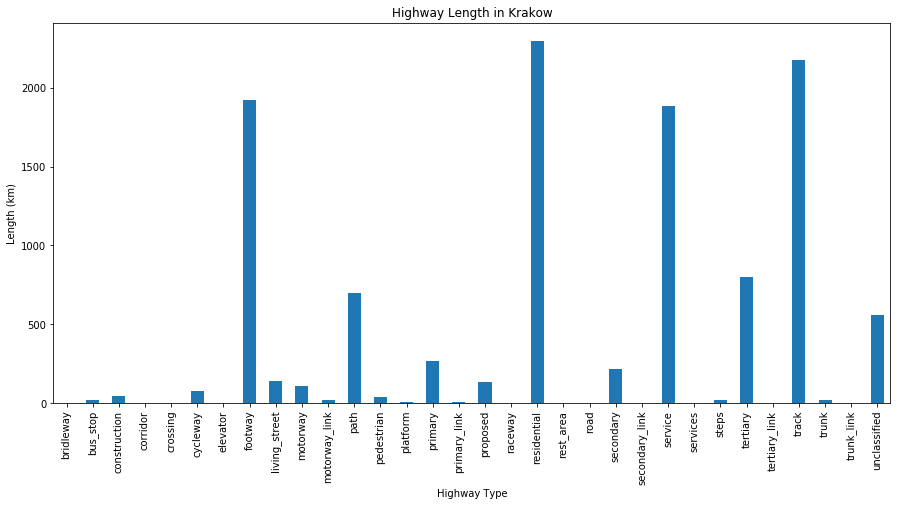

In [57]:

data = df2.groupby('Highways')
data.size()
data_total = (data.sum())/1000

my_plot = data_total.plot(kind='bar',legend=None,title="Highway Length in Krakow", figsize=(15,7))
my_plot.set_xlabel("Highway Type")
my_plot.set_ylabel("Length (km)")

# Presenting the Table with Lenghts of the roads ordered from the Biggest to the Smallest

In [58]:
df2['Lenght (KM)'] = df2['Total Lenght']/1000
df2

,Highways,Total Lenght,Lenght (KM)
0,residential,2.296844e+06,2296.843911
1,track,2.176083e+06,2176.082844
2,footway,1.919978e+06,1919.977894
3,service,1.883521e+06,1883.520683
4,tertiary,8.010958e+05,801.095803
5,path,6.999229e+05,699.922910
6,unclassified,5.593805e+05,559.380525
7,primary,2.653279e+05,265.327857
8,secondary,2.168265e+05,216.826538
9,living_street,1.419390e+05,141.938979
